In [ ]:
# !pip install --quiet stable_baselines3
# !pip install --quiet import_ipynb
# !git clone https://github.com/gmshroff/aiagentarch.git
# %cd aiagentarch

In [1]:
import gym
from gym import spaces
from gym import Env
import random
import numpy as np
from threading import Thread
import threading
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv,VecFrameStack,StackedObservations
from stable_baselines3.common.monitor import Monitor as Mon

In [2]:
# for thread in threading.enumerate(): 
#     print(thread.name)

In [3]:
# for thread in threading.enumerate(): 
#     print(thread.name)

### Agent-based RL in Simple Worlds with windowing and Meta-RL

- using window of states in case where velocity is masked
- can use meta-RL: **TBD test with varying physics in a CL setting**

In [4]:
class MaskedPole(Env):
    def __init__(self):
        super().__init__()
        self.env=gym.make('CartPole-v1')
        self.action_space=self.env.action_space
        self.observation_space=self.env.observation_space
    def reset(self):
        obs=self.env.reset()
        # print(obs)
        obs[1]=0
        obs[3]=0
        return obs
    def step(self,action):
        obs, rewards, dones, info = self.env.step(action)
        # print(obs)
        obs[1]=0
        obs[3]=0
        return obs, rewards, dones, info
    def render(self,mode="human"):
        self.env.render()

In [6]:
env = MaskedPole()

In [7]:
import import_ipynb
from aiagentbase import AIAgent,Controller,Memory,Perception,Actor

importing Jupyter notebook from aiagentbase.ipynb


In [9]:
class GenWorld():
    def __init__(self,env):
        self.env=env
        self.test_episodes=[]
        self.world_over=False
    def stop(self):
        self.world_over=True
    def run(self,agent=None,n_episodes=10,episode_maxlen=10):
        agent.observation_space=env.observation_space
        if 'training' not in agent.__dict__: agent.training=False
        if agent.training: testing=False 
        else: testing=True
        if agent.training: print('Starting Training time: ',agent.time)
        for episode in range(n_episodes):
            # print('CartAgent','starting episode')
            state=self.env.reset()
            agent.begin()
            # print(agent.time)#,agent.ep)
            for t in range(episode_maxlen):
                # env.render(mode='rgb_array')
                action=agent.act(state)
                # print(episode,t,'Action: ', action)
                state, reward, done, info = env.step(action)
                agent.reward((reward,done,info))
                # print(episode,t,'Reward sent: ', reward)
                if done:
                    break
            if self.world_over:break
            if not agent.training: self.test_episodes+=[episode]
            if not agent.training and not testing: 
                print('Training Over at time: ',agent.time)
                testing=True
                self.world_over=True
        print('Testing Done time: ', agent.time, ' Reward: ', agent.avg_rew())
        return agent.avg_rew()

In [10]:
#Doesnt use AIAgent Architecture Classes but implements the same interface - for initial testing
class RandomAgent():
    def __init__(self,action_space):
        self.action_space=action_space
        self.tot_rew=0
        self.rewL=[]
    def act(self,state):
        action = self.action_space.sample()
        return action
    def reward(self,rew):
        self.tot_rew+=rew[0]
    def begin(self,state):
        self.rewL+=[self.tot_rew]
    def avg_rew(self):
        return sum(self.rewL)/len(self.rewL)

In [11]:
class RandomAIAgent(AIAgent):
    def __init__(self,action_space):
        super().__init__()
        self.actor=self.Actor(parent=self)
        self.action_space=action_space
        self.tot_rew=0
        self.rewL=[]
        
    class Actor(Actor):
        def __init__(self,parent): 
            super().__init__(parent=parent)
        def call_model(self,state):
        ##Overriding AIAgent.Model
            action = self.parent.action_space.sample()
            return action
        def compute_reward(self,reward):
            return reward[0]
    
    def reward(self,rew):
        ##Augmenting AIAgent
        self.tot_rew+=rew[0]
        return super().reward(rew)
    def begin(self):
        ##Augmenting AIAgent
        self.rewL+=[self.tot_rew]
        super().begin()
    def avg_rew(self):
        return sum(self.rewL)/len(self.rewL)

In [12]:
agent=RandomAIAgent(env.action_space)
agent.training=False

In [13]:
agent.debug=False
agent.use_memory=True

In [14]:
agent.limit_memory=True
agent.memory.limit_perceptual=2
agent.memory.limit_sar=4

In [15]:
world=GenWorld(env=env)

In [16]:
agent.tot_rew,agent.rewL,agent.ep=0,[],[]

In [17]:
worldthread=Thread(name='world',target=world.run,args=(agent,1000,200))

In [18]:
worldthread.start()

Testing Done time:  22138  Reward:  11070.0


In [19]:
agent.avg_rew()/len(agent.ep)

11.07

In [20]:
# world.run(agent,10,10)

In [21]:
# agent.memory.perceptual_memory

### Training an AI Agent's Model using Generic RL Agent

In [22]:
from threading import Thread
import threading
import sys

In [23]:
from queue import Queue

In [24]:
from aiagentbase import RLAgent

In [26]:
training_steps=20000

In [46]:
agent=RLAgent(algoclass=PPO,monclass=Mon,action_space=env.action_space,observation_space=env.observation_space,
              verbose=1,win=1,soclass=StackedObservations,metarl=False)

Using cpu device
Wrapping the env in a DummyVecEnv.


In [47]:
agent.debug=False
agent.use_memory=True
agent.training=True

In [48]:
agent.rewL=[]
agent.tot_rew=0
agent.ep=[]

In [49]:
if agent.training: agent.start(training_steps=training_steps)

In [50]:
world=GenWorld(env=env)

In [51]:
# worldthread=Thread(name='world',target=world.run,args=(agent,2000,200))

In [52]:
# worldthread.start()

In [53]:
world.run(agent,n_episodes=2000,episode_maxlen=200)

Starting Training time:  0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21.5     |
|    ep_rew_mean     | 21.5     |
| time/              |          |
|    fps             | 895      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 24.9         |
|    ep_rew_mean          | 24.9         |
| time/                   |              |
|    fps                  | 1314         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0065468773 |
|    clip_fraction        | 0.0112       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.692       |
|    explained_variance   | 0.0

8780.734589041096

In [54]:
import pandas as pd
df=pd.read_csv('/tmp/aiagents.monitor.csv',comment='#')

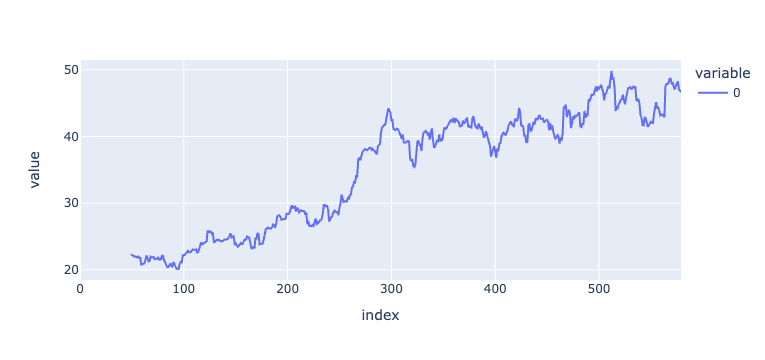

In [55]:
import plotly.express as px
px.line(df['r'].rolling(window=50).mean().values).show()

In [56]:
# len(agent.logL)

In [57]:
from matplotlib import pyplot as plt

In [58]:
# testing_len=len([agent.rewL[t] for t in world.test_episodes])

In [59]:
# testing_len

In [60]:
# agent.rewL

In [61]:
print(np.gradient(agent.rewL).mean())

35.23373287671233


In [62]:
# plt.plot(np.gradient(agent.rewL))

In [66]:
episodes = 50
rewL=[]
agent.training=False
for episode in range(1, episodes+1):
    done = False
    score = 0 
    steps=0
    state = env.reset()
    while not done and steps<=200:
        action = agent.act(state)
        state, reward, done, info = env.step(action)
        env.render()
        score+=reward
        steps+=1
    # print('Episode:{} Score:{}'.format(episode, score))
    rewL+=[score]
env.close()

In [64]:
# from matplotlib import pyplot as plt
# import numpy as np

In [65]:
print(np.array(rewL).mean())

41.82


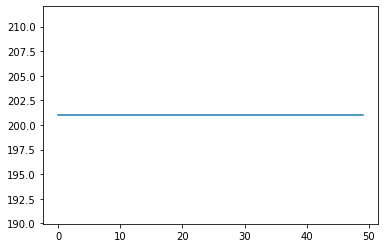

In [45]:
plt.plot(rewL)

In [ ]:
# PPO??